In [49]:
import xarray as xr
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import pandas as pd

plt.style.use('fivethirtyeight')

# Reading model outputs

In [50]:
runoff_uncalib = xr.open_dataset('/gpfs/fs1/work/manab/fcast/basins/hhdw1/output/uncalibrated/summaout.nc').set_index(hru='hruId')
route_uncalib = xr.open_dataset('/gpfs/fs1/work/manab/fcast/basins/hhdw1/output/uncalibrated/summaroute.nc').set_index(seg='reachID')

obs = xr.open_dataset('/gpfs/fs1/work/manab/fcast/data/obs/obsflow.dly.HHDW1.nc')

sid = 23977690 #23977692 #Outlet segment
hid = 171100130203 #HUC-12 immediately upstream to outlet
stime='2010-12-01' # For entire run. Removing first run to account for no warm up
etime='2014-09-30'

In [51]:
print('List of SUMMA output variables: \n' + str(list(runoff_uncalib.variables)) + '\n')
print('List of mizuRoute output variables: \n' + str(list(route_uncalib.variables)))

List of SUMMA output variables: 
['time', 'hru', 'pptrate', 'airtemp', 'nSnow', 'nSoil', 'nLayers', 'scalarCanopyIce', 'scalarCanopyLiq', 'scalarSWE', 'mLayerTemp', 'mLayerVolFracLiq', 'scalarAquiferStorage', 'scalarTotalSoilLiq', 'scalarTotalSoilIce', 'scalarTotalSoilWat', 'scalarCanopySublimation', 'scalarSnowSublimation', 'scalarCanopyTranspiration', 'scalarCanopyEvaporation', 'scalarGroundEvaporation', 'scalarRainPlusMelt', 'scalarSoilBaseflow', 'scalarSoilDrainage', 'scalarAquiferRecharge', 'scalarAquiferTranspire', 'scalarAquiferBaseflow', 'averageInstantRunoff']

List of mizuRoute output variables: 
['time', 'basinID', 'basRunoff', 'instRunoff', 'dlayRunoff', 'sumUpstreamRunoff', 'KWTroutedRunoff', 'IRFroutedRunoff', 'seg']


# Unit conversions

In [52]:
units = {
    "pptrate":3600,                   #kg m-2 s-1 -> mm/hr  
    "averageInstantRunoff":3600000,   #m/s to mm/h
    "scalarAquiferBaseflow":3600000,  #m/s to mm/h
    "scalarRainPlusMelt":3600000,     #m/s to mm/h
    "scalarAquiferRecharge":3600000,  #m/s to mm/h
    "scalarAquiferStorage":1000,      #m to mm
    "scalarAquiferTranspire":3600000, #m/s to mm/h
    "scalarSurfaceRunoff":3600000,    #m/s to mm/h
    "basRunoff":3600000,              #m/s to mm/h
}

def unitConvert(ncdat, ncvar):
    '''
    Converts units of all SUMMA outputs to mm scale
    
    ncdat: netCDF data
    ncvar: variable to be converted
    '''
    ncdat[ncvar] = ncdat[ncvar]*units[ncvar]
 
# Uncalibrated
runoff_uncalib['ET']=(runoff_uncalib['scalarGroundEvaporation']+runoff_uncalib['scalarCanopyEvaporation']+runoff_uncalib['scalarCanopyEvaporation']+runoff_uncalib['scalarCanopyEvaporation']+runoff_uncalib['scalarCanopySublimation'])*3600
runoff_uncalib['airtemp'] = runoff_uncalib['airtemp']-273.15   #K to celcius
unitConvert(runoff_uncalib, 'pptrate')
unitConvert(runoff_uncalib, 'averageInstantRunoff')
unitConvert(runoff_uncalib, 'scalarAquiferStorage')
unitConvert(runoff_uncalib, 'scalarAquiferBaseflow')
unitConvert(runoff_uncalib, 'scalarAquiferTranspire')
unitConvert(runoff_uncalib, 'scalarRainPlusMelt')
unitConvert(runoff_uncalib, 'scalarAquiferRecharge')
unitConvert(route_uncalib, 'basRunoff')

# Calibrated

# Plotting water balance components 

In [53]:
def subplotCreator(ncdat, ylab, plotnumber):
    ncdat.plot(ax=axarr[plotnumber], color='#1f78b4')
    axarr[plotnumber].set_title('')
    axarr[plotnumber].set_xlabel('')
    axarr[plotnumber].set_ylabel(ylab, rotation='horizontal')
    axarr[plotnumber].yaxis.set_label_coords(-0.25, 0.25)

pptrate=runoff_uncalib.sel(hru=hid)['pptrate'].loc[stime:etime]
rainmelt=runoff_uncalib.sel(hru=hid)['scalarRainPlusMelt'].loc[stime:etime]
airtemp=runoff_uncalib.sel(hru=hid)['airtemp'].loc[stime:etime]
swe=runoff_uncalib.sel(hru=hid)['scalarSWE'].loc[stime:etime]
et=runoff_uncalib.sel(hru=hid)['ET'].loc[stime:etime]
sm=runoff_uncalib.sel(hru=hid)['scalarTotalSoilWat'].loc[stime:etime]
aqstorage=runoff_uncalib.sel(hru=hid)['scalarAquiferStorage'].loc[stime:etime]
aqrecharge=runoff_uncalib.sel(hru=hid)['scalarAquiferRecharge'].loc[stime:etime]
aqbaseflow=runoff_uncalib.sel(hru=hid)['scalarAquiferBaseflow'].loc[stime:etime]
hucrunoff=runoff_uncalib.sel(hru=hid)['averageInstantRunoff'].loc[stime:etime]
streamflow=route_uncalib.sel(seg=sid)['KWTroutedRunoff'].loc[stime:etime]

route2=route_uncalib.copy()
nhdrunoff=route2.set_index(hru='basinID').sel(hru=sid)['basRunoff'].loc[stime:etime]

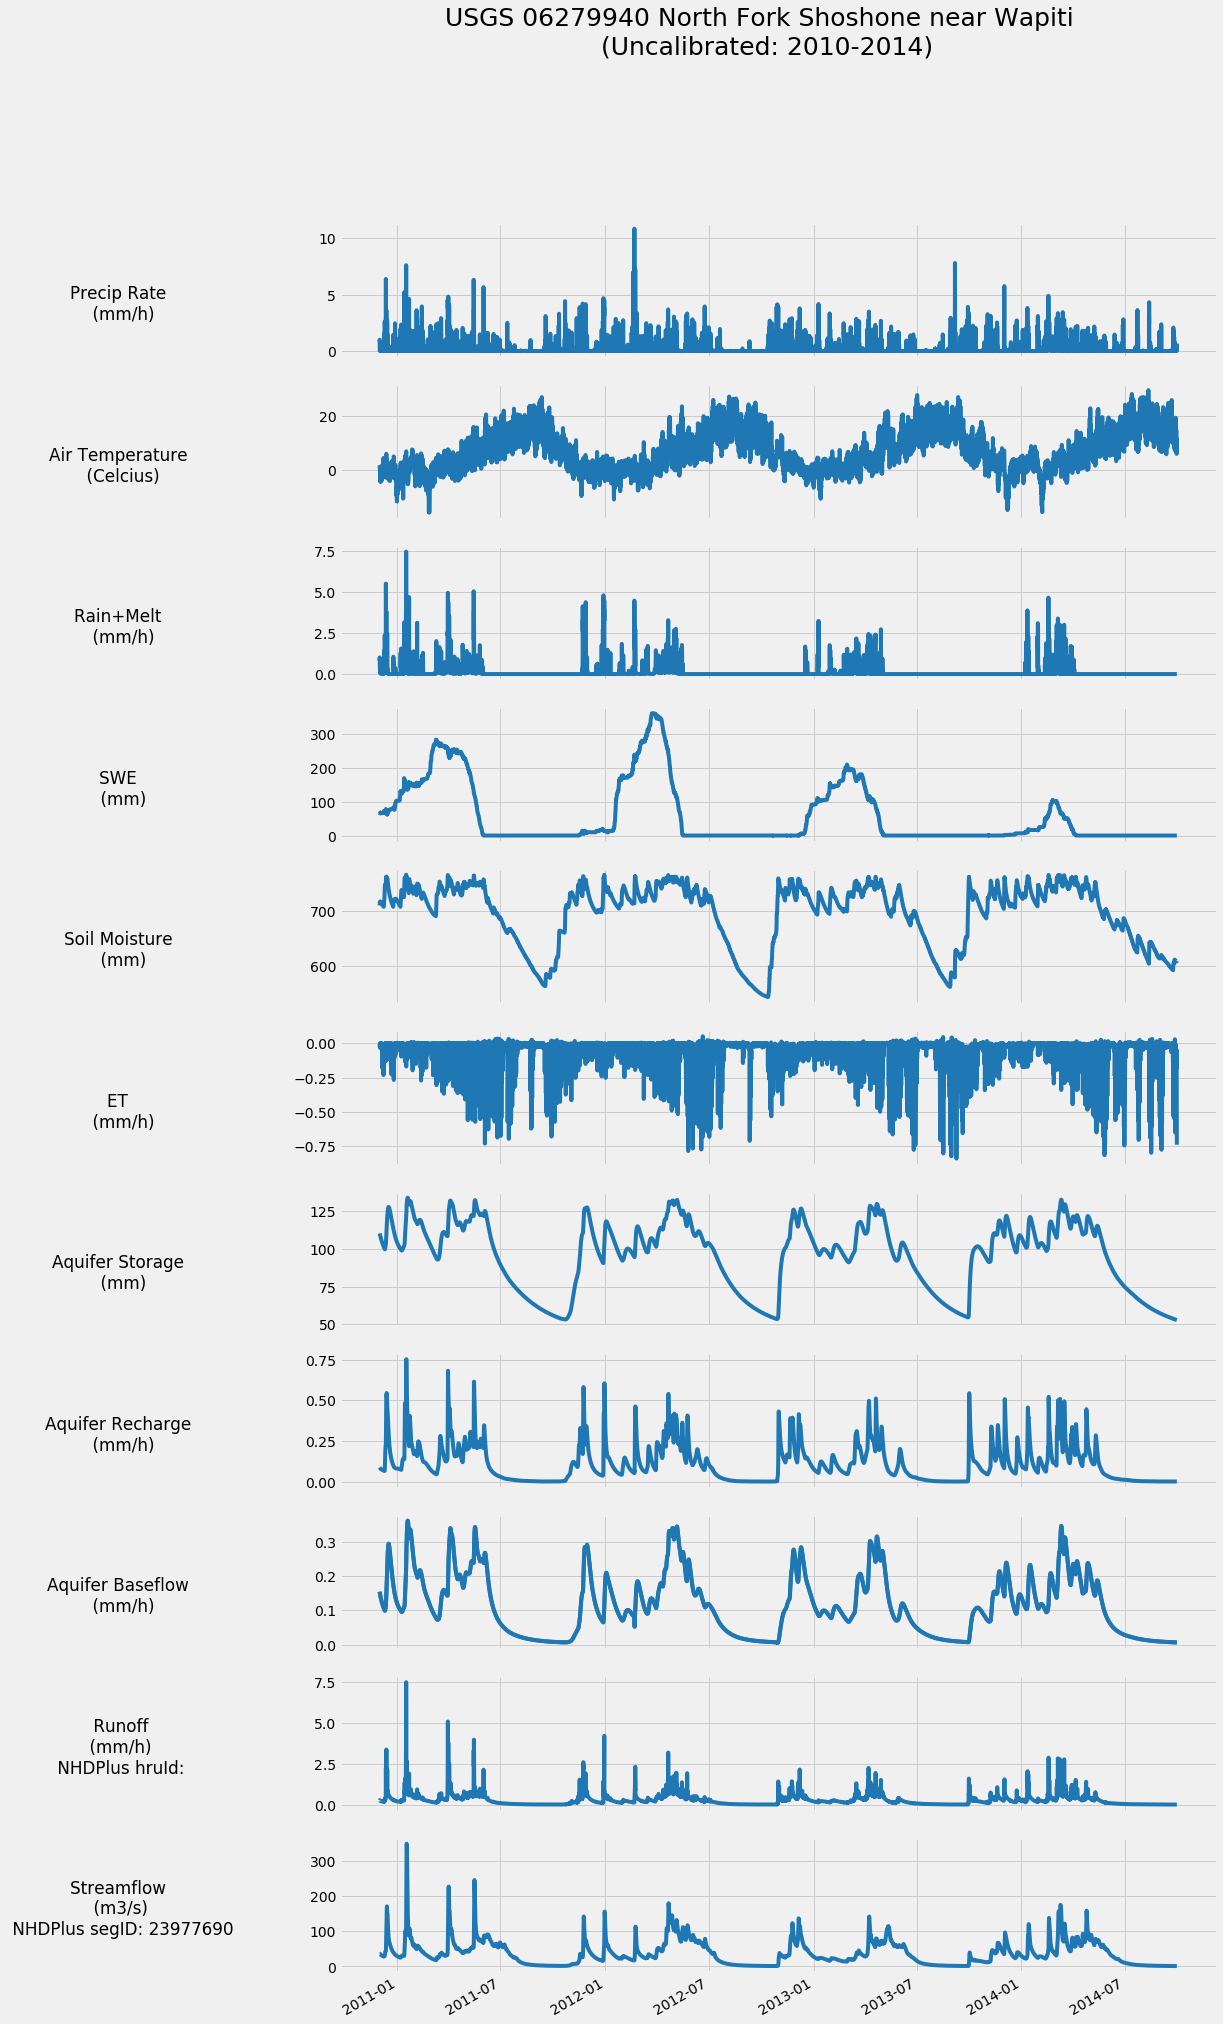

In [54]:
fig, axarr = plt.subplots(nrows=11, figsize=(14,30), sharex=True)
fig.suptitle("USGS 06279940 North Fork Shoshone near Wapiti \n (Uncalibrated: 2010-2014)", size=25)

subplotCreator(pptrate, 'Precip Rate \n (mm/h)', 0)
subplotCreator(airtemp, 'Air Temperature \n (Celcius)', 1)
subplotCreator(rainmelt, 'Rain+Melt \n (mm/h)', 2)
subplotCreator(swe, 'SWE \n (mm)', 3)
subplotCreator(sm, 'Soil Moisture \n (mm)', 4)
subplotCreator(et, 'ET \n (mm/h)', 5)
subplotCreator(aqstorage, 'Aquifer Storage \n (mm)', 6)
subplotCreator(aqrecharge, 'Aquifer Recharge \n (mm/h)', 7)
subplotCreator(aqbaseflow, 'Aquifer Baseflow \n (mm/h)', 8)
subplotCreator(aqbaseflow, 'Aquifer Baseflow \n (mm/h)', 8)
#subplotCreator(hucrunoff, 'Runoff \n (mm/h) \n HUC-12 hruId: '+str(hid), 9)
subplotCreator(hucrunoff, ' Runoff \n (mm/h) \n NHDPlus hruId: ', 9)
subplotCreator(streamflow, 'Streamflow \n (m3/s) \n NHDPlus segID: ' + str(sid), 10)

# Streamflow verification

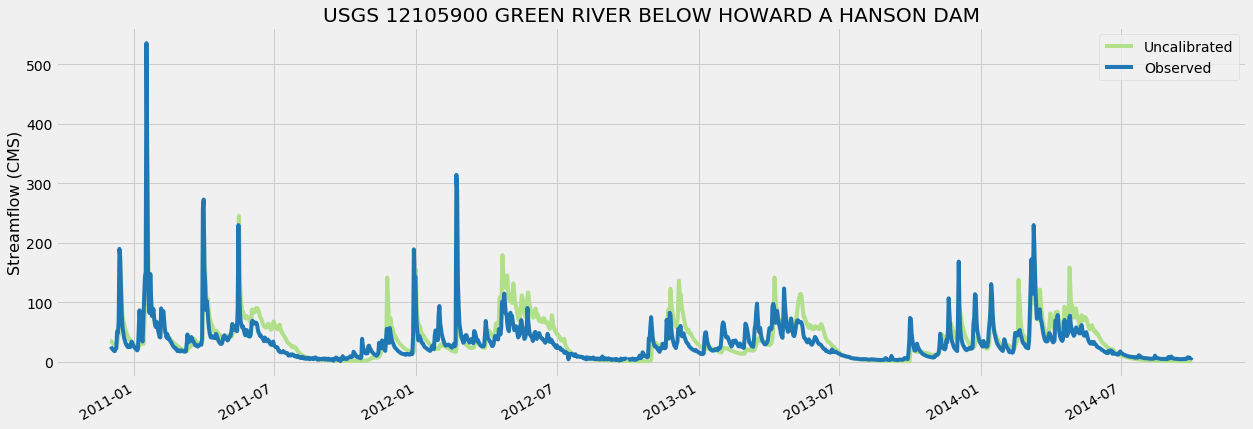

In [56]:
plt.figure(figsize=(19,6))
route_uncalib.sel(seg=sid)['KWTroutedRunoff'].loc[stime:etime].plot(label="Uncalibrated", color='#b2df8a')
obs['flow'].loc[stime:etime].plot(label="Observed", color='#1f78b4')
plt.title("USGS 12105900 GREEN RIVER BELOW HOWARD A HANSON DAM")
plt.ylabel('Streamflow (CMS)', fontsize=16)
plt.xlabel('')
plt.legend()
plt.show()